In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from twopoint import twopoint
import plot
import joblib
from numpy.lib import recfunctions as rfn
import treecorr
import os


In [2]:
fpath = Path("giulia_2pt/giulia_2pt_example.fits")
ffile = fits.open(fpath)
del ffile[4:6]
del ffile[-1]

In [3]:
weaklens_dir = Path.cwd().parent.parent
run_dir = weaklens_dir / "inhomogeneity_sims" / "imprint_sims" / "DES" / "nladd" / "psf10x_A"


In [4]:
import pickle

npairs_dict = {}

for i in range(0, 4):
    for j in range(0, i + 1):
        pickle_file = run_dir / "gg_r{0}{1}.pickle".format(j, i)
        print(pickle_file)
        with open(pickle_file, 'rb') as f:
            gg_data = pickle.load(f)
            npairs_dict[(j + 1, i + 1)] = gg_data.npairs

/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r00.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r01.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r11.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r02.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r12.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r22.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r03.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r13.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r23.pickle
/home/shrihan/weaklens/inhomogeneity_sims/imprint_sims/DES/nladd/psf10x_A/gg_r33.pickle


In [5]:
cross_xip = {}
cross_xim = {}
theta_corr = {}

# Load the xip and jackknife uncertainty in xip from treecorr for each binning
for i in range(0, 4):
    for j in range(0, i + 1):
        cross_xip[(j + 1, i + 1)] = np.load(run_dir / "xip_corr_r{0}{1}.npy".format(j, i))
        cross_xim[(j + 1, i + 1)] = np.load(run_dir / "xim_corr_r{0}{1}.npy".format(j, i))
        theta_corr[(j + 1, i + 1)] = np.load(run_dir / "theta_corr_r{0}{1}.npy".format(j, i))

In [6]:
xip_data = ffile[2].data
xim_data = ffile[3].data

val_xip = np.zeros(10 * 20)
val_xim = np.zeros(10 * 20)
npairs = np.zeros(10 * 20)

for i in range(len(val_xip)):
    val_xip[i] = cross_xip[(xip_data['BIN1'][i], xip_data['BIN2'][i])][xip_data['ANGBIN'][i]]
    val_xim[i] = cross_xim[(xim_data['BIN1'][i], xim_data['BIN2'][i])][xim_data['ANGBIN'][i]]
    npairs[i] = npairs_dict[(xip_data['BIN1'][i], xip_data['BIN2'][i])][xip_data['ANGBIN'][i]]
    
xip_data['VALUE'] = val_xip
xim_data['VALUE'] = val_xim
xip_data['NPAIRS'] = npairs
xim_data['NPAIRS'] = npairs

# Changing the NPAIRS column to 1 doesnt make a diff, but using treecorr output anyway
# xip_data['NPAIRS']  = 1
# xim_data['NPAIRS']  = 1

# Dropping the NPAIRS column causes errors
# xip_b = rfn.drop_fields(xip_data, 'NPAIRS')
# xim_b = rfn.drop_fields(xim_data, 'NPAIRS')

ffile[2].data = xip_data
ffile[3].data = xim_data


!cat ../cosmocow/covs/output/out_cov_desy3_shrihan_fp_rt2_norm_ng/d* > shrihan/covdata.txt

In [15]:
import plot

In [16]:
cov_g, cov_ng, ndata = plot.get_cov("covdata.txt")
cov = cov_g + cov_ng
pp_norm = np.zeros((ndata,ndata))
for i in range(ndata):
    for j in range(ndata):
        pp_norm[i][j] = cov[i][j]/ np.sqrt(cov[i][i]*cov[j][j])
        
plt.imshow(pp_norm, cmap = 'seismic', vmin = -1, vmax = 1)
plt.colorbar()
plt.title("Final Covariance")

Dimension of cov: 400x400


Text(0.5, 1.0, 'Final Covariance')

In [8]:
ffile[1].header.pop('STRT_2', None)
ffile[1].header.pop('NAME_2', None)
ffile[1].header.pop('STRT_3', None)
ffile[1].header.pop('NAME_3', None)
ffile[1].header['NAXIS1'] = 400
ffile[1].header['NAXIS2'] = 400
ffile[1].data = cov

In [9]:
des_data = run_dir.parent.parent / "DES_Data"

with open(des_data / 'z_sources_y3.pkl', 'rb') as f:
    ztomo = joblib.load(f)
with open(des_data / 'nz_sources_y3.pkl', 'rb') as f:
    nztomo = joblib.load(f)

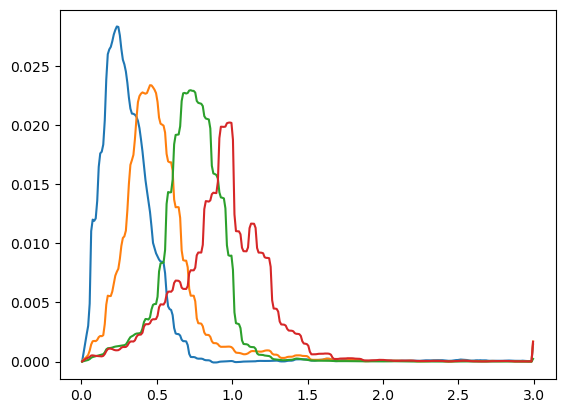

In [10]:
plt.plot(ztomo, nztomo[0], label = 'Source 1')
plt.plot(ztomo, nztomo[1], label = 'Source 2')
plt.plot(ztomo, nztomo[2], label = 'Source 3')
plt.plot(ztomo, nztomo[3], label = 'Source 4')

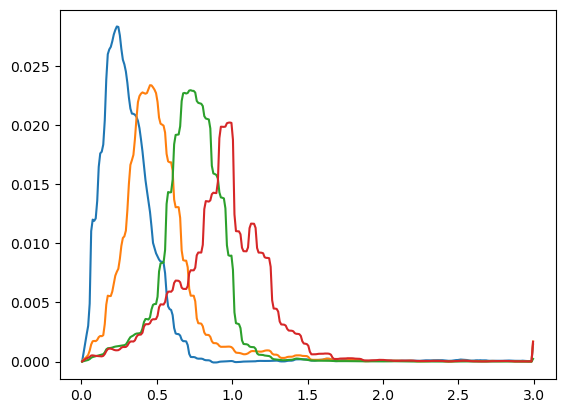

In [11]:
plt.plot(ffile[4].data['Z_MID'], ffile[4].data['BIN1'], label = 'Source 1')
plt.plot(ffile[4].data['Z_MID'], ffile[4].data['BIN2'], label = 'Source 2')
plt.plot(ffile[4].data['Z_MID'], ffile[4].data['BIN3'], label = 'Source 3')
plt.plot(ffile[4].data['Z_MID'], ffile[4].data['BIN4'], label = 'Source 4')

In [12]:
n_density = [1.475584985490327, 
             1.479383426887689,
             1.483671693529899,
             1.461247850098986]

sigma_all = [0.243, 0.262, 0.259, 0.301]

zhead = ffile[4].header
zhead['NBIN'] = 4
zhead['NZ'] = 300

for i in range(4):
    zhead[f'NGAL_{i + 1}'] = n_density[i]
for i in range(4):
    zhead[f'SIG_E_{i + 1}'] = sigma_all[i]

zdata = ffile[4].data
z_a = np.recarray(len(ztomo), dtype=zdata.dtype)
z_b = rfn.drop_fields(z_a, 'BIN5')
znew = rfn.drop_fields(z_b, 'BIN6')
del z_a, z_b
znew['Z_MID'] = ztomo
znew['Z_LOW'] = ztomo - ztomo[0]
znew['Z_HIGH'] = ztomo + ztomo[0]
for i in range(4):
    znew[f'BIN{i + 1}'] = nztomo[i]
ffile[4].data = znew



In [13]:
save_dirname = Path("psf10x_A_2pt")
os.makedirs(save_dirname, exist_ok=True)
os.makedirs(save_dirname / "figures", exist_ok=True)
savepath = save_dirname / "psf10x_A_2pt.fits"

# orig_dirname = Path("giulia_2pt")
# os.makedirs(orig_dirname, exist_ok=True)
# os.makedirs(orig_dirname / "figures", exist_ok=True)
# opath = orig_dirname / "giulia_2pt_example.fits"

ffile.writeto(savepath, overwrite=True)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

T2 = twopoint.TwoPointFile.from_fits(opath)
oldpath = opath.parent / "figures" / opath.stem
T2.plots(oldpath, colormap='viridis', savepdf=False, latex=False, plot_spectrum=True, plot_kernel=True, plot_cov=True, cov_vmin=None, sharey=True, save_pickle=False, load_pickle=False, remove_pickle=True,label_legend ='', blind_yaxis=False, shade_until=None)

In [14]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

T3 = twopoint.TwoPointFile.from_fits(savepath)
spath = savepath.parent / "figures" / savepath.stem
T3.plots(spath, colormap='viridis', savepdf=False, latex=False, plot_spectrum=True, plot_kernel=True, plot_cov=True, cov_vmin=None, sharey=True, save_pickle=False, load_pickle=False, remove_pickle=True,label_legend ='', blind_yaxis=False, shade_until=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving psf10x_A_2pt/figures/psf10x_A_2pt_xip


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saving psf10x_A_2pt/figures/psf10x_A_2pt_xim
Saving psf10x_A_2pt/figures/psf10x_A_2pt_nz_source
Saving psf10x_A_2pt/figures/psf10x_A_2pt_cov


In [15]:
savefile = fits.open(savepath)
oldfile = fits.open(opath)

NameError: name 'opath' is not defined

In [22]:
savefile.info()

Filename: fiducialA_2pt/fiducialA_2pt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        13   (400, 400)   float64   
  2  xip           1 BinTableHDU     39   200R x 8C   [K, K, K, D, D, D, D, D]   
  3  xim           1 BinTableHDU     39   200R x 8C   [K, K, K, D, D, D, D, D]   
  4  nz_source     1 BinTableHDU     34   300R x 7C   [D, D, D, D, D, D, D]   


In [23]:
oldfile.info()

Filename: giulia_2pt/giulia_2pt_example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        17   (1000, 1000)   float64   
  2  xip           1 BinTableHDU     39   200R x 8C   [K, K, K, D, D, D, D, D]   
  3  xim           1 BinTableHDU     39   200R x 8C   [K, K, K, D, D, D, D, D]   
  4  gammat        1 BinTableHDU     37   480R x 7C   [K, K, K, D, D, D, D]   
  5  wtheta        1 BinTableHDU     39   120R x 8C   [K, K, K, D, D, D, D, D]   
  6  nz_source     1 BinTableHDU     32   300R x 7C   [D, D, D, D, D, D, D]   
  7  nz_lens       1 BinTableHDU     34   150R x 9C   [D, D, D, D, D, D, D, D, D]   
